In [295]:
import pandas as pd
import os
import yfinance as yf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats

In [296]:
def get_company_files(name):
    """
    Retrieves the corresponding DATA and WHS files for a given company name and adds return calculations.
    
    Parameters:
    name (str): Company name (e.g., 'NKE', 'WFC')
    df (pandas.DataFrame): DataFrame containing the mapping of names to ConIDs
    
    Returns:
    tuple: (data_file, whs_file) DataFrames for the company with fixed column alignment and returns
    """
    
    
    df = pd.read_excel("alle data fixed\Stock names and countries.xlsx")
    df = df.drop('Unnamed: 0', axis=1)
    
    # Find the ConID for the given company name
    company_row = df[df['Name'] == name.upper()]
    
    if company_row.empty:
        print(f"Company {name} not found in the DataFrame")
        return None, None
    
    # Get the ConID
    conid = str(company_row['ConID'].iloc[0])
    
    # Read the price data file
    data_file = pd.read_csv(os.path.join("alle data fixed", f"{conid}_DATA.csv"))
    
    # Fix the column alignment
    correct_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 
                      'NumberOfTrades', 'VWAP', 'IM_Open', 'IM_High', 'IM_Low', 
                      'IM_Close', 'SV_Open', 'SV_Open.1', 'SV_Open.2', 'SV_Open.3']
    
    # Shift all values one column to the left and drop the last column
    data_file = data_file.iloc[:, :-1]  # Remove the first column (unnamed index)
    data_file.columns = correct_columns  # Set the correct column names
    data_file = data_file.reset_index(drop=True)  # Reset and remove the index
    
    # Convert price data date to datetime
    data_file['Date'] = pd.to_datetime(data_file['Date'])
    
    # Calculate returns
    data_file['Return'] = data_file['Close'].pct_change()
    
    # Get S&P 500 data
    start_date = data_file['Date'].min()
    end_date = data_file['Date'].max()
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)
    sp500['Return'] = sp500['Close'].pct_change()
    
    # Merge with stock data
    data_file = data_file.merge(sp500['Return'], 
                               left_on='Date', 
                               right_index=True, 
                               how='left',
                               suffixes=('', '_SP500'))
    
    # Calculate excess return
    data_file['Excess_Return'] = data_file['Return'] - data_file['Return_SP500']
    
    # Read the WHS file
    whs_file = pd.read_csv(os.path.join("alle data fixed", f"{conid}_WHS.csv"))
    whs_file = whs_file.iloc[:,1:-4]
    whs_file = whs_file.reset_index(drop=True)  # Reset and remove the index
    
    # Convert all date columns in WHS file to datetime
    date_columns = ['announce_date', 'record_date', 'ex_div_date', 'pay_date']
    for col in date_columns:
        if col == 'announce_date':
            whs_file[col] = pd.to_datetime(whs_file[col])
        else:
            # Convert the numeric format to string then to datetime
            whs_file[col] = pd.to_datetime(whs_file[col].astype(str).str.slice(-8), format='%Y%m%d')
    
    return data_file, whs_file

In [297]:
# Read the Excel file
df = pd.read_excel("alle data fixed\Stock names and countries.xlsx")
df = df.drop('Unnamed: 0', axis=1)
df.head()

,Name,ConID,Currency
0,NKE,10291,US
1,WFC,10375,US
2,RAND,10428270,EU
3,PG,11054,US
4,USB,11669769,US


In [298]:
price_data, dividend_data = get_company_files('NKE')
price_data.head()

C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume,NumberOfTrades,VWAP,IM_Open,IM_High,IM_Low,IM_Close,SV_Open,SV_Open.1,SV_Open.2,SV_Open.3,Return,Return_SP500,Excess_Return
0,2017-10-17,51.37,52.04,51.25,52.00,8738544,41663,51.889,0.0131,0.0132,0.0127,0.0128,0.0131,0.0132,0.0127,0.0128,NaN,NaN,NaN
1,2017-10-18,52.06,52.40,51.83,52.30,10220523,42626,52.222,0.0126,0.0135,0.0126,0.0127,0.0126,0.0135,0.0126,0.0127,0.005769,0.000742,0.005027
2,2017-10-19,52.00,52.80,51.15,52.69,11521396,50603,52.468,0.0125,0.0138,0.0125,0.0128,0.0125,0.0138,0.0125,0.0128,0.007457,0.000328,0.007129
3,2017-10-20,52.82,53.50,52.66,53.18,12053980,44086,53.108,0.0129,0.0135,0.0124,0.0127,0.0129,0.0135,0.0124,0.0127,0.009300,0.005117,0.004183
4,2017-10-23,53.07,53.95,53.00,53.65,11379126,43634,53.694,0.0125,0.0139,0.0125,0.0132,0.0125,0.0139,0.0125,0.0132,0.008838,-0.003972,0.012810


In [299]:
dividend_data.head()

,event_type,announce_date,record_date,ex_div_date,pay_date,dividend_oc,amount_oc,change_percent,change_amount,fiscal_year
0,wshe_div,2018-11-15,2018-12-03,2018-11-30,2019-01-02,0.220,NaN,10.0%,0.020,2019
1,wshe_div,2019-02-14,2019-03-04,2019-03-01,2019-04-01,0.220,NaN,0.0%,0.000,2019
2,wshe_div,2019-05-09,2019-06-03,2019-05-31,2019-07-01,0.220,NaN,0.0%,0.000,2019
3,wshe_div,2019-08-08,2019-09-03,2019-08-30,2019-09-30,0.220,NaN,0.0%,0.000,2020
4,wshe_div,2019-11-14,2019-12-02,2019-11-29,2020-01-02,0.245,NaN,11.4%,0.025,2020


C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


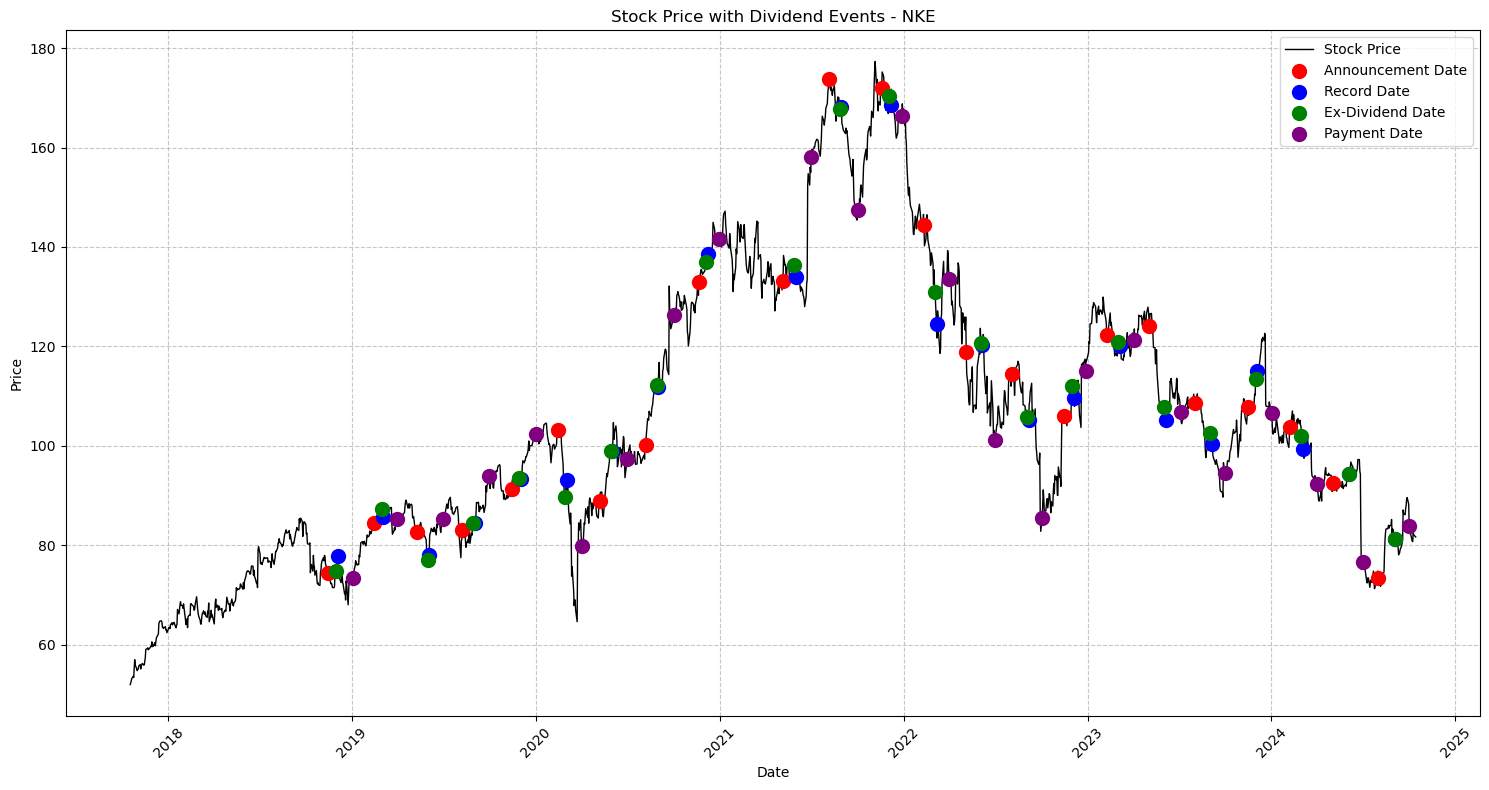

In [301]:
def plot_stock_with_events(ticker):
    """
    Creates a plot of stock prices with dividend events marked as colored dots.
    
    Parameters:
    ticker (str): Stock ticker symbol (e.g., 'NKE')
    """
    import matplotlib.pyplot as plt
    
    # Get the data using the first function
    price_data, dividend_data = get_company_files(ticker)  # Note: df needs to be accessible
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    # Plot stock price
    plt.plot(price_data['Date'], price_data['Close'], label='Stock Price', color='black', linewidth=1)
    
    # Plot different events with different colors
    colors = {
        'announce_date': ('red', 'Announcement Date'),
        'record_date': ('blue', 'Record Date'),
        'ex_div_date': ('green', 'Ex-Dividend Date'),
        'pay_date': ('purple', 'Payment Date')
    }
    
    # Add dots for each event type
    for date_col, (color, label) in colors.items():
        for event_date in dividend_data[date_col]:
            # Find the stock price on this date (or nearest date)
            price_on_date = price_data.set_index('Date').asof(event_date)['Close']
            plt.scatter(event_date, price_on_date, c=color, s=100, label=label, zorder=5)
        
    # Remove duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    # Customize the plot
    plt.title(f'Stock Price with Dividend Events - {ticker}', fontsize=12)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    return plt

# Usage:
plot = plot_stock_with_events('NKE')
plot.show()  # or plot.savefig('stock_plot.png')

In [302]:
def calculate_returns_around_date(price_data, event_idx):
    """
    Calculate returns for different periods around an event date.
    Uses existing Return and Excess_Return columns from price_data.
    """
    returns = {}
    
    try:
        # Week before return (t-5 to t)
        week_before_idx = max(0, event_idx - 5)
        if week_before_idx < event_idx:
            price_start = price_data.iloc[week_before_idx]['Close']
            price_end = price_data.iloc[event_idx]['Close']
            returns['week_before_return'] = (price_end / price_start) - 1
            
            # Use cumulative excess returns for the period
            excess_returns = price_data.iloc[week_before_idx:event_idx + 1]['Excess_Return']
            returns['week_before_excess_return'] = ((1 + excess_returns).prod() - 1)
        
        # Day before return (t-1 to t)
        day_before_idx = max(0, event_idx - 1)
        if day_before_idx < event_idx:
            price_start = price_data.iloc[day_before_idx]['Close']
            price_end = price_data.iloc[event_idx]['Close']
            returns['day_before_return'] = (price_end / price_start) - 1
            returns['day_before_excess_return'] = price_data.iloc[day_before_idx]['Excess_Return']
        
        # Event day return (t to t+1)
        if event_idx + 1 < len(price_data):
            price_start = price_data.iloc[event_idx]['Close']
            price_end = price_data.iloc[event_idx + 1]['Close']
            returns['event_day_return'] = (price_end / price_start) - 1
            returns['event_day_excess_return'] = price_data.iloc[event_idx]['Excess_Return']
        
        # Day after return (t+1 to t+2)
        if event_idx + 2 < len(price_data):
            price_start = price_data.iloc[event_idx + 1]['Close']
            price_end = price_data.iloc[event_idx + 2]['Close']
            returns['day_after_return'] = (price_end / price_start) - 1
            returns['day_after_excess_return'] = price_data.iloc[event_idx + 1]['Excess_Return']
        
        # Week after return (t to t+5)
        if event_idx + 5 < len(price_data):
            price_start = price_data.iloc[event_idx]['Close']
            price_end = price_data.iloc[event_idx + 5]['Close']
            returns['week_after_return'] = (price_end / price_start) - 1
            
            # Use cumulative excess returns for the period
            excess_returns = price_data.iloc[event_idx:event_idx + 6]['Excess_Return']
            returns['week_after_excess_return'] = ((1 + excess_returns).prod() - 1)
            
    except Exception as e:
        print(f"Error calculating returns: {str(e)}")
    
    return returns

def analyze_dividend_events(base_path="alle data fixed"):
    """
    Analyzes returns around all dividend event types.
    Returns a dictionary with DataFrames for each event type.
    """
    # Read the stock names mapping file
    df = pd.read_excel(f"{base_path}/Stock names and countries.xlsx")
    df = df.drop('Unnamed: 0', axis=1)
    
    # Initialize storage for each event type
    event_types = ['announce_date', 'record_date', 'ex_div_date', 'pay_date']
    all_events = {event_type: [] for event_type in event_types}
    
    # Loop through each company
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            name = row['Name']
            price_data, whs_file = get_company_files(name)
            
            if price_data is None or whs_file is None:
                continue
            
            # Process each event type
            for event_type in event_types:
                for event_date in whs_file[event_type]:
                    try:
                        # Find the index of the event date in price data
                        mask = price_data['Date'] >= event_date
                        if not any(mask):
                            continue
                        event_idx = price_data[mask].index[0]
                        
                        # Calculate returns around the event
                        returns = calculate_returns_around_date(price_data, event_idx)
                        
                        if returns:  # Only add if we have return data
                            event_data = {
                                'stock': name,
                                'event_date': event_date,
                                'event_type': event_type,
                                **returns  # Unpack all returns into the dictionary
                            }
                            all_events[event_type].append(event_data)
                            
                    except Exception as e:
                        print(f"Error processing {event_type} for {name}: {str(e)}")
                        
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")
    
    # Convert lists to DataFrames
    event_dfs = {}
    for event_type in event_types:
        if all_events[event_type]:  # Only create DataFrame if we have events
            event_dfs[event_type] = pd.DataFrame(all_events[event_type])
    
    return event_dfs

In [303]:
def plot_return_distributions(events_dict, event_type):
    """
    Creates visualizations of return distributions for a specific event type.
    """
    if event_type not in events_dict:
        print(f"No data available for {event_type}")
        return None
        
    events_df = events_dict[event_type]
    
    # Set up the plots
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot raw returns
    return_cols = [col for col in events_df.columns if 'return' in col and 'excess' not in col]
    return_data = events_df[return_cols].melt()
    return_data['variable'] = return_data['variable'].str.replace('_return', '')
    
    sns.boxplot(x='variable', y='value', data=return_data, ax=axes[0])
    axes[0].set_title(f'Distribution of Raw Returns Around {event_type.replace("_", " ").title()}')
    axes[0].set_xlabel('Period')
    axes[0].set_ylabel('Return')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot excess returns
    excess_cols = [col for col in events_df.columns if 'excess' in col]
    excess_data = events_df[excess_cols].melt()
    excess_data['variable'] = excess_data['variable'].str.replace('_excess_return', '')
    
    sns.boxplot(x='variable', y='value', data=excess_data, ax=axes[1])
    axes[1].set_title(f'Distribution of Excess Returns Around {event_type.replace("_", " ").title()}')
    axes[1].set_xlabel('Period')
    axes[1].set_ylabel('Excess Return')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return plt

def generate_summary_statistics(events_dict, event_type):
    """
    Generates summary statistics for a specific event type.
    """
    if event_type not in events_dict:
        print(f"No data available for {event_type}")
        return None, None
        
    events_df = events_dict[event_type]
    
    # Separate raw and excess returns
    raw_returns = events_df[[col for col in events_df.columns if 'return' in col and 'excess' not in col]]
    excess_returns = events_df[[col for col in events_df.columns if 'excess' in col]]
    
    # Calculate summary statistics
    raw_summary = raw_returns.agg(['count', 'mean', 'median', 'std', 'skew']).round(4)
    excess_summary = excess_returns.agg(['count', 'mean', 'median', 'std', 'skew']).round(4)
    
    # Add t-test for significance
    for col in raw_returns.columns:
        t_stat, p_value = stats.ttest_1samp(raw_returns[col].dropna(), 0)
        raw_summary.loc['t_stat', col] = round(t_stat, 4)
        raw_summary.loc['p_value', col] = round(p_value, 4)
    
    for col in excess_returns.columns:
        t_stat, p_value = stats.ttest_1samp(excess_returns[col].dropna(), 0)
        excess_summary.loc['t_stat', col] = round(t_stat, 4)
        excess_summary.loc['p_value', col] = round(p_value, 4)
    
    return raw_summary, excess_summary

def print_readable_summary(raw_summary, excess_summary, event_type):
    """
    Prints a more readable summary of the results with statistical significance.
    """
    print(f"\nSummary of Returns Around {event_type.replace('_', ' ').title()}:")
    print("=" * 80)
    
    # Function to format period name
    def format_period(col):
        return col.replace('_return', '').replace('_', ' ').title()
    
    # Print raw returns
    print("\nRaw Returns:")
    for col in raw_summary.columns:
        period = format_period(col)
        mean = raw_summary.loc['mean', col] * 100
        t_stat = raw_summary.loc['t_stat', col]
        p_value = raw_summary.loc['p_value', col]
        stars = '*' * sum([p_value < 0.05, p_value < 0.01, p_value < 0.001])
        
        print(f"\n{period}:")
        print(f"  Mean Return: {mean:.2f}% {stars}")
        print(f"  t-statistic: {t_stat:.2f}")
        print(f"  p-value: {p_value:.4f}")
    
    # Print excess returns
    print("\nExcess Returns (Compared to S&P 500):")
    for col in excess_summary.columns:
        period = format_period(col)
        mean = excess_summary.loc['mean', col] * 100
        t_stat = excess_summary.loc['t_stat', col]
        p_value = excess_summary.loc['p_value', col]
        stars = '*' * sum([p_value < 0.05, p_value < 0.01, p_value < 0.001])
        
        print(f"\n{period}:")
        print(f"  Mean Excess Return: {mean:.2f}% {stars}")
        print(f"  t-statistic: {t_stat:.2f}")
        print(f"  p-value: {p_value:.4f}")
    
    print("\nNote: * p<0.05, ** p<0.01, *** p<0.001")

In [304]:
# Get data for all event types
events_dict = analyze_dividend_events()

  0%|          | 0/92 [00:00<?, ?it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
  1%|          | 1/92 [00:00<01:12,  1.26it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
  2%|▏         | 2/92 [00:01<01:15,  1.19it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd

Error processing FLOW: [Errno 2] No such file or directory: 'alle data fixed\\199679493_DATA.csv'


C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 20%|█▉        | 18/92 [00:11<00:35,  2.08it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 21%|██        | 19/92 [00:11<00:32,  2.22it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index +=

[*********************100%%**********************]  1 of 1 completed
 42%|████▏     | 39/92 [00:23<00:21,  2.49it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 43%|████▎     | 40/92 [00:23<00:20,  2.54it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 45%|████▍     | 41/92 [00:24<00:17,  3.00it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in Timedelta

Error processing WDP: [Errno 2] No such file or directory: 'alle data fixed\\396411105_DATA.csv'



 57%|█████▋    | 52/92 [00:28<00:15,  2.60it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 58%|█████▊    | 53/92 [00:29<00:17,  2.18it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 59%|█████▊    | 54/92 [00:29<00:16,  2.27it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future ver

Error processing FAGR: [Errno 2] No such file or directory: 'alle data fixed\\46592631_DATA.csv'


C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 71%|███████   | 65/92 [00:35<00:13,  2.02it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 72%|███████▏  | 66/92 [00:35<00:12,  2.01it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index +=

[*********************100%%**********************]  1 of 1 completed
 93%|█████████▎| 86/92 [00:47<00:05,  1.09it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 95%|█████████▍| 87/92 [00:48<00:04,  1.14it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 96%|█████████▌| 88/92 [00:49<00:03,  1.13it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in Timedelta

In [305]:
print("Available event types:", list(events_dict.keys()))
# 'announce_date', 'record_date', 'ex_div_date', 'pay_date'

Available event types: ['announce_date', 'record_date', 'ex_div_date', 'pay_date']



Analyzing announce_date...


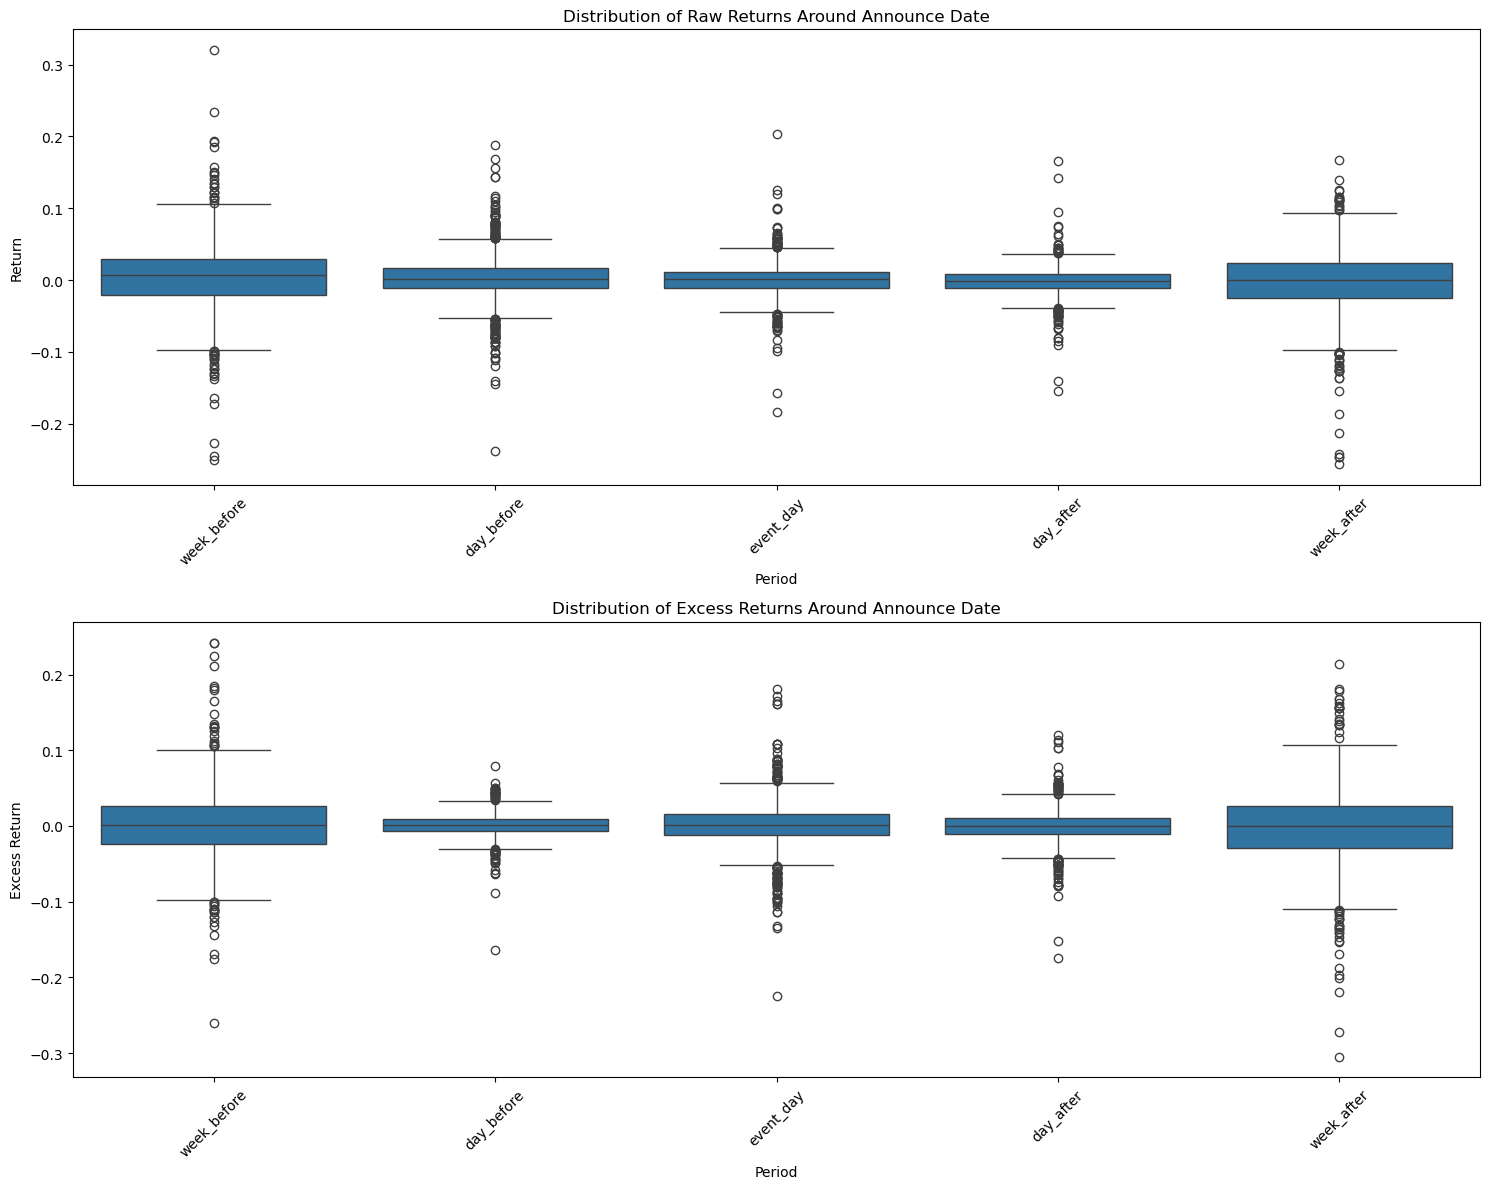


Summary of Returns Around Announce Date:

Raw Returns:

Week Before:
  Mean Return: 0.46% **
  t-statistic: 3.14
  p-value: 0.0017

Day Before:
  Mean Return: 0.23% *
  t-statistic: 2.19
  p-value: 0.0288

Event Day:
  Mean Return: 0.04% 
  t-statistic: 0.58
  p-value: 0.5630

Day After:
  Mean Return: -0.14% *
  t-statistic: -2.33
  p-value: 0.0200

Week After:
  Mean Return: -0.20% 
  t-statistic: -1.53
  p-value: 0.1263

Excess Returns (Compared to S&P 500):

Week Before Excess:
  Mean Excess Return: 0.25% 
  t-statistic: 1.83
  p-value: 0.0682

Day Before Excess:
  Mean Excess Return: 0.12% *
  t-statistic: 2.43
  p-value: 0.0152

Event Day Excess:
  Mean Excess Return: 0.18% 
  t-statistic: 1.77
  p-value: 0.0763

Day After Excess:
  Mean Excess Return: -0.02% 
  t-statistic: -0.32
  p-value: 0.7493

Week After Excess:
  Mean Excess Return: -0.14% 
  t-statistic: -0.90
  p-value: 0.3694

Note: * p<0.05, ** p<0.01, *** p<0.001


In [306]:
# Analyze each event type
event_type = 'announce_date'
print(f"\nAnalyzing {event_type}...")

#Plotting
plot = plot_return_distributions(events_dict, event_type)
plot.show()
        
# Get summary statistics
raw_summary, excess_summary = generate_summary_statistics(events_dict, event_type)
print_readable_summary(raw_summary, excess_summary, event_type)


Analyzing record_date...


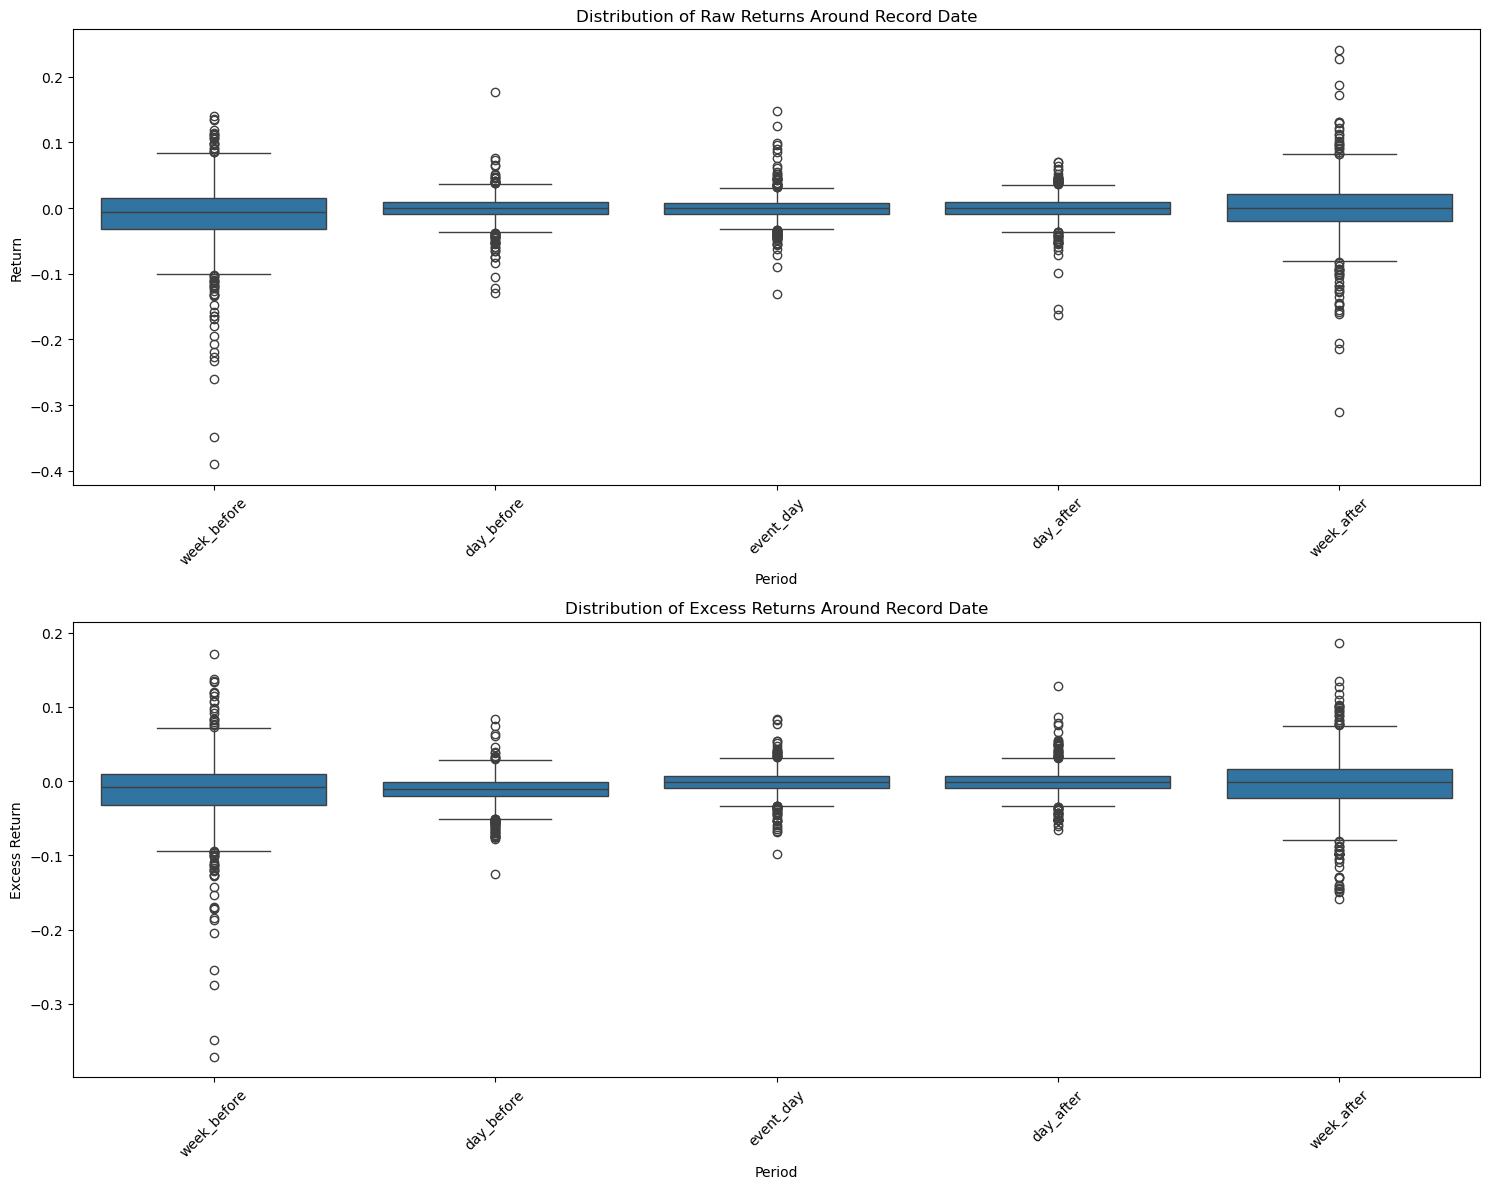


Summary of Returns Around Record Date:

Raw Returns:

Week Before:
  Mean Return: -0.99% ***
  t-statistic: -7.15
  p-value: 0.0000

Day Before:
  Mean Return: -0.03% 
  t-statistic: -0.47
  p-value: 0.6400

Event Day:
  Mean Return: -0.02% 
  t-statistic: -0.33
  p-value: 0.7403

Day After:
  Mean Return: -0.04% 
  t-statistic: -0.77
  p-value: 0.4432

Week After:
  Mean Return: -0.01% 
  t-statistic: -0.07
  p-value: 0.9462

Excess Returns (Compared to S&P 500):

Week Before Excess:
  Mean Excess Return: -1.26% ***
  t-statistic: -9.70
  p-value: 0.0000

Day Before Excess:
  Mean Excess Return: -1.17% ***
  t-statistic: -20.44
  p-value: 0.0000

Event Day Excess:
  Mean Excess Return: -0.08% 
  t-statistic: -1.69
  p-value: 0.0920

Day After Excess:
  Mean Excess Return: -0.09% 
  t-statistic: -1.72
  p-value: 0.0851

Week After Excess:
  Mean Excess Return: -0.31% **
  t-statistic: -2.82
  p-value: 0.0048

Note: * p<0.05, ** p<0.01, *** p<0.001


In [307]:
# Analyze each event type
event_type = 'record_date'
print(f"\nAnalyzing {event_type}...")

#Plotting
plot = plot_return_distributions(events_dict, event_type)
plot.show()
        
# Get summary statistics
raw_summary, excess_summary = generate_summary_statistics(events_dict, event_type)
print_readable_summary(raw_summary, excess_summary, event_type)


Analyzing ex_div_date...


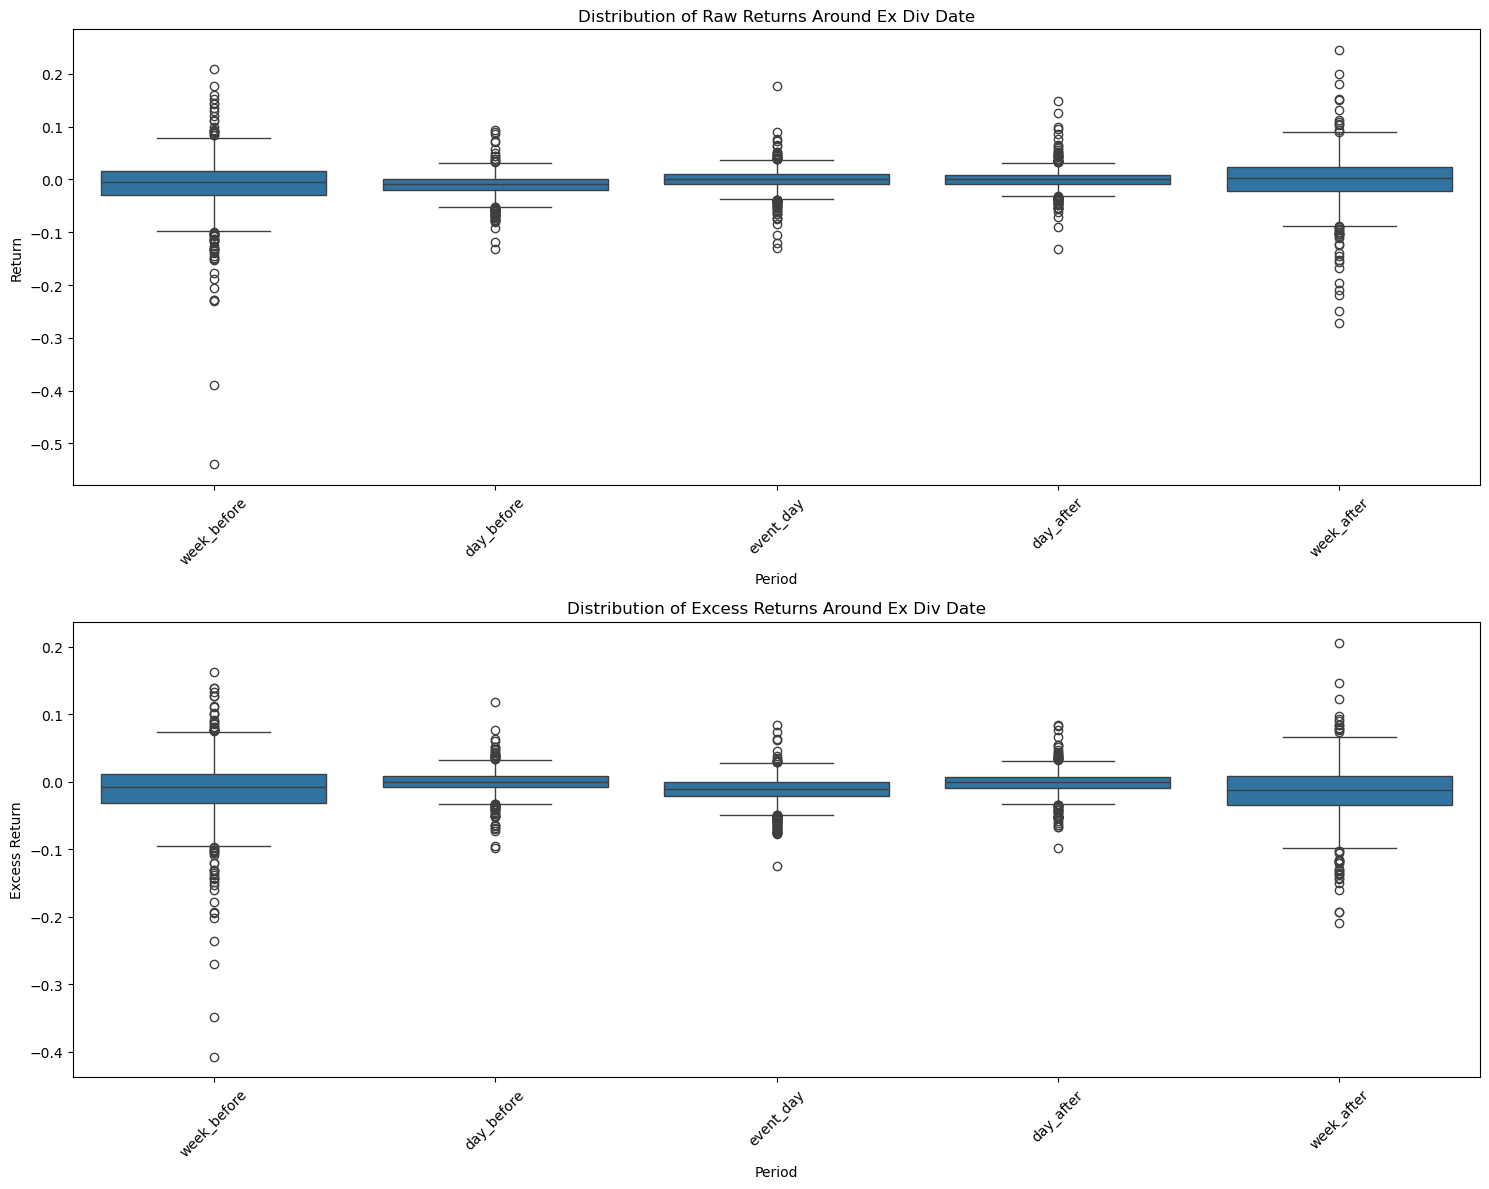


Summary of Returns Around Ex Div Date:

Raw Returns:

Week Before:
  Mean Return: -0.91% ***
  t-statistic: -6.39
  p-value: 0.0000

Day Before:
  Mean Return: -1.09% ***
  t-statistic: -17.56
  p-value: 0.0000

Event Day:
  Mean Return: -0.04% 
  t-statistic: -0.70
  p-value: 0.4859

Day After:
  Mean Return: 0.01% 
  t-statistic: 0.23
  p-value: 0.8197

Week After:
  Mean Return: -0.05% 
  t-statistic: -0.39
  p-value: 0.6958

Excess Returns (Compared to S&P 500):

Week Before Excess:
  Mean Excess Return: -1.15% ***
  t-statistic: -8.63
  p-value: 0.0000

Day Before Excess:
  Mean Excess Return: -0.07% 
  t-statistic: -1.37
  p-value: 0.1702

Event Day Excess:
  Mean Excess Return: -1.20% ***
  t-statistic: -21.05
  p-value: 0.0000

Day After Excess:
  Mean Excess Return: -0.12% *
  t-statistic: -2.40
  p-value: 0.0166

Week After Excess:
  Mean Excess Return: -1.46% ***
  t-statistic: -12.66
  p-value: 0.0000

Note: * p<0.05, ** p<0.01, *** p<0.001


In [308]:
# Analyze each event type
event_type = 'ex_div_date'
print(f"\nAnalyzing {event_type}...")

#Plotting
plot = plot_return_distributions(events_dict, event_type)
plot.show()
        
# Get summary statistics
raw_summary, excess_summary = generate_summary_statistics(events_dict, event_type)
print_readable_summary(raw_summary, excess_summary, event_type)


Analyzing pay_date...


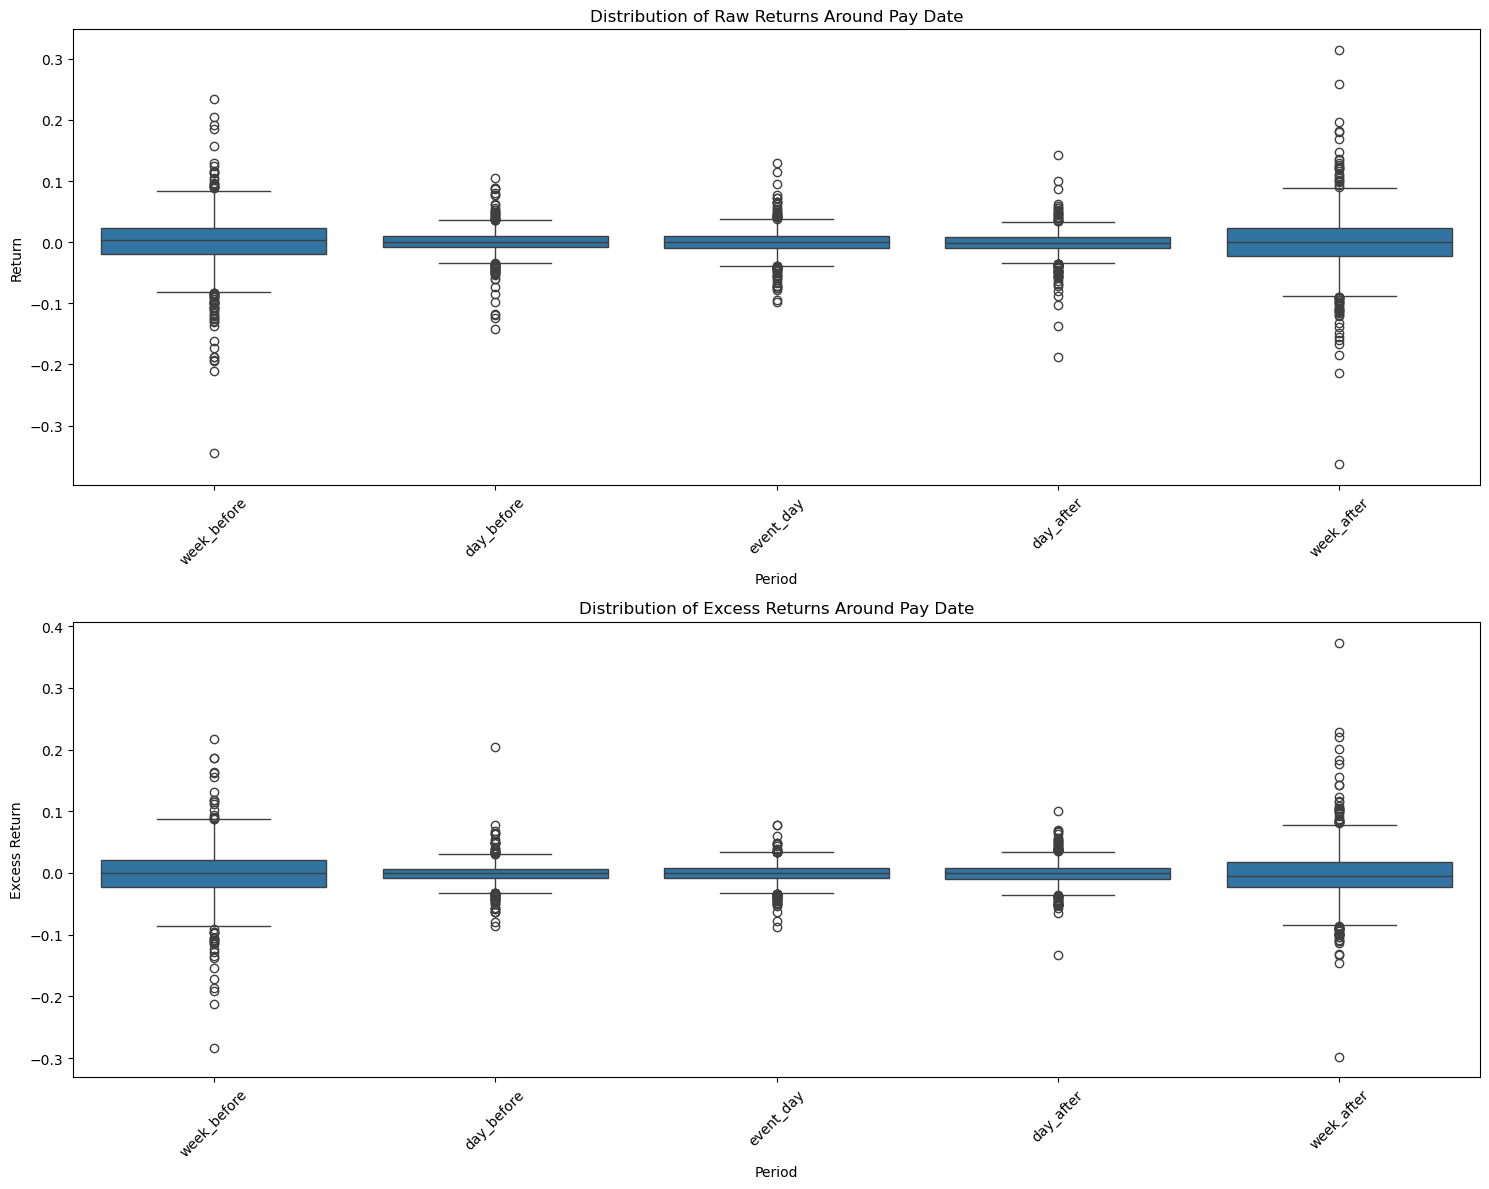


Summary of Returns Around Pay Date:

Raw Returns:

Week Before:
  Mean Return: 0.05% 
  t-statistic: 0.37
  p-value: 0.7095

Day Before:
  Mean Return: 0.08% 
  t-statistic: 1.41
  p-value: 0.1592

Event Day:
  Mean Return: -0.01% 
  t-statistic: -0.18
  p-value: 0.8566

Day After:
  Mean Return: -0.15% *
  t-statistic: -2.57
  p-value: 0.0102

Week After:
  Mean Return: -0.11% 
  t-statistic: -0.77
  p-value: 0.4389

Excess Returns (Compared to S&P 500):

Week Before Excess:
  Mean Excess Return: -0.10% 
  t-statistic: -0.85
  p-value: 0.3949

Day Before Excess:
  Mean Excess Return: -0.07% 
  t-statistic: -1.41
  p-value: 0.1588

Event Day Excess:
  Mean Excess Return: -0.02% 
  t-statistic: -0.40
  p-value: 0.6880

Day After Excess:
  Mean Excess Return: -0.06% 
  t-statistic: -1.24
  p-value: 0.2157

Week After Excess:
  Mean Excess Return: -0.25% *
  t-statistic: -1.99
  p-value: 0.0468

Note: * p<0.05, ** p<0.01, *** p<0.001


In [309]:
# Analyze each event type
event_type = 'pay_date'
print(f"\nAnalyzing {event_type}...")

#Plotting
plot = plot_return_distributions(events_dict, event_type)
plot.show()
        
# Get summary statistics
raw_summary, excess_summary = generate_summary_statistics(events_dict, event_type)
print_readable_summary(raw_summary, excess_summary, event_type)

In [310]:
def visualize_event_study(event_data, days_before=30, days_after=30):
    """
    Create visualization with final color scheme: green (***), orange (**), light orange (*), red (ns)
    """
    # Calculate daily statistics
    daily_stats = event_data.groupby('days_from_event').agg({
        'excess_return': [
            ('mean', lambda x: np.mean(x)),
            ('std', lambda x: np.std(x)),
            ('count', 'count')
        ]
    }).reset_index()
    
    daily_stats.columns = ['days_from_event', 'mean', 'std', 'n']
    
    # Calculate t-statistics and p-values
    daily_stats['t_stat'] = daily_stats['mean'] / (daily_stats['std'] / np.sqrt(daily_stats['n']))
    daily_stats['p_value'] = 2 * (1 - stats.t.cdf(abs(daily_stats['t_stat']), df=daily_stats['n'] - 1))
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot confidence intervals as dashed lines
    ci_upper = daily_stats['mean'] + daily_stats['std']
    ci_lower = daily_stats['mean'] - daily_stats['std']
    
    # Set day 0 confidence intervals to mean value
    zero_idx = daily_stats[daily_stats['days_from_event'] == 0].index
    if len(zero_idx) > 0:
        ci_upper.iloc[zero_idx] = daily_stats['mean'].iloc[zero_idx]
        ci_lower.iloc[zero_idx] = daily_stats['mean'].iloc[zero_idx]
    
    ax.plot(daily_stats['days_from_event'], ci_upper, 
            color='blue', linestyle='--', alpha=0.3, linewidth=1)
    ax.plot(daily_stats['days_from_event'], ci_lower, 
            color='blue', linestyle='--', alpha=0.3, linewidth=1)
    
    # Plot mean excess returns
    ax.plot(daily_stats['days_from_event'], daily_stats['mean'], 
            color='blue', linewidth=2, label='Mean Excess Return')
    
    # Add significance level background coloring
    for _, row in daily_stats.iterrows():
        if row['days_from_event'] == 0:
            color = 'white'
            alpha = 1.0
        else:
            p_val = row['p_value']
            
            if p_val >= 0.1:  # Not significant
                color = '#FF4500'  # Red
                alpha = 0.3
            elif p_val < 0.1 and p_val >= 0.05:  # * significance
                color = '#FFA500'  # Orange
                alpha = 0.3
            elif p_val < 0.05 and p_val >= 0.01:  # ** significance
                color = '#FF8C00'  # Dark orange
                alpha = 0.3
            else:  # *** significance
                color = '#98FB98'  # Pale green
                alpha = 0.3
        
        ax.axvspan(row['days_from_event'] - 0.5,
                  row['days_from_event'] + 0.5,
                  facecolor=color,
                  alpha=alpha,
                  edgecolor='none')
    
    # Add reference lines
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    # Customize plot
    ax.set_title('Event Study: Mean Excess Returns Around Record Date', fontsize=12, pad=15)
    ax.set_xlabel('Days from Event', fontsize=10)
    ax.set_ylabel('Excess Return', fontsize=10)
    ax.set_xlim(-days_before, days_after)
    
    # Add significance level legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#98FB98', alpha=0.3, label='*** p < 0.01'),
        Patch(facecolor='#FF8C00', alpha=0.3, label='** p < 0.05'),
        Patch(facecolor='#FFA500', alpha=0.3, label='* p < 0.1'),
        Patch(facecolor='#FF4500', alpha=0.3, label='Not significant')
    ]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    
    # Modified summary analysis section
    print("\nEvent Study Summary Analysis:")
    print("=============================")
    
    # Analyze pre-event period
    pre_event = daily_stats[daily_stats['days_from_event'].between(-5, -1)]
    most_sig_pre = pre_event.loc[pre_event['t_stat'].abs().idxmax()]
    
    print("\nPre-Event Period Analysis:")
    print(f"Most significant effect at day {most_sig_pre['days_from_event']}")
    print(f"Mean excess return: {most_sig_pre['mean']*100:.2f}% [{(most_sig_pre['mean']-most_sig_pre['std'])*100:.2f}%, {(most_sig_pre['mean']+most_sig_pre['std'])*100:.2f}%]")
    print(f"t-statistic: {most_sig_pre['t_stat']:.2f}")
    print(f"p-value: {most_sig_pre['p_value']:.4f}")
    
    # Pattern Analysis
    negative_days = daily_stats[daily_stats['days_from_event'] < 0]
    significant_negative = negative_days[abs(negative_days['t_stat']) > 1.96]
    
    print("\nPattern Analysis:")
    print(f"Number of significant days (|t| > 1.96) before event: {len(significant_negative)}")
    print(f"Average t-statistic magnitude before event: {negative_days['t_stat'].abs().mean():.2f}")
    
    if len(significant_negative) > 0:
        print("\nMost significant pre-event days:")
        sig_days = significant_negative.sort_values('t_stat')
        for _, day in sig_days.head(3).iterrows():
            ci_lower = (day['mean'] - day['std']) * 100
            ci_upper = (day['mean'] + day['std']) * 100
            print(f"Day {int(day['days_from_event'])}: {day['mean']*100:.2f}% [{ci_lower:.2f}%, {ci_upper:.2f}%]")
            print(f"  t-statistic: {day['t_stat']:.2f}")
            print(f"  p-value: {day['p_value']:.4f}")
    
    return fig, daily_stats

In [311]:
event_data = get_event_study_data(base_path="alle data fixed", event_type='record_date', days_before=30, days_after=30)

  0%|          | 0/92 [00:00<?, ?it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
  1%|          | 1/92 [00:02<03:23,  2.23s/it]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
  2%|▏         | 2/92 [00:04<03:14,  2.16s/it]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd

Error processing FLOW: [Errno 2] No such file or directory: 'alle data fixed\\199679493_DATA.csv'


C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 20%|█▉        | 18/92 [00:24<01:24,  1.14s/it]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 21%|██        | 19/92 [00:24<01:14,  1.02s/it]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index +=

[*********************100%%**********************]  1 of 1 completed
 42%|████▏     | 39/92 [00:49<00:32,  1.65it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 43%|████▎     | 40/92 [00:50<00:31,  1.66it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 45%|████▍     | 41/92 [00:50<00:23,  2.15it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in Timedelta

Error processing WDP: [Errno 2] No such file or directory: 'alle data fixed\\396411105_DATA.csv'



 57%|█████▋    | 52/92 [00:58<00:32,  1.24it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 58%|█████▊    | 53/92 [01:00<00:36,  1.08it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 59%|█████▊    | 54/92 [01:00<00:32,  1.16it/s]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future ver

Error processing FAGR: [Errno 2] No such file or directory: 'alle data fixed\\46592631_DATA.csv'


C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 71%|███████   | 65/92 [01:12<00:29,  1.09s/it]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 72%|███████▏  | 66/92 [01:13<00:26,  1.02s/it]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index +=

[*********************100%%**********************]  1 of 1 completed
 93%|█████████▎| 86/92 [01:38<00:10,  1.82s/it]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 95%|█████████▍| 87/92 [01:40<00:09,  1.93s/it]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
 96%|█████████▌| 88/92 [01:42<00:07,  1.89s/it]C:\Users\westm\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in Timedelta


Event Study Summary Analysis:

Pre-Event Period Analysis:
Most significant effect at day -2.0
Mean excess return: -1.27% [-3.95%, 1.41%]
t-statistic: -15.74
p-value: 0.0000

Pattern Analysis:
Number of significant days (|t| > 1.96) before event: 30
Average t-statistic magnitude before event: 6.52

Most significant pre-event days:
Day -2: -1.27% [-3.95%, 1.41%]
  t-statistic: -15.74
  p-value: 0.0000
Day -3: -1.38% [-4.41%, 1.66%]
  t-statistic: -15.07
  p-value: 0.0000
Day -4: -1.38% [-5.12%, 2.36%]
  t-statistic: -12.25
  p-value: 0.0000


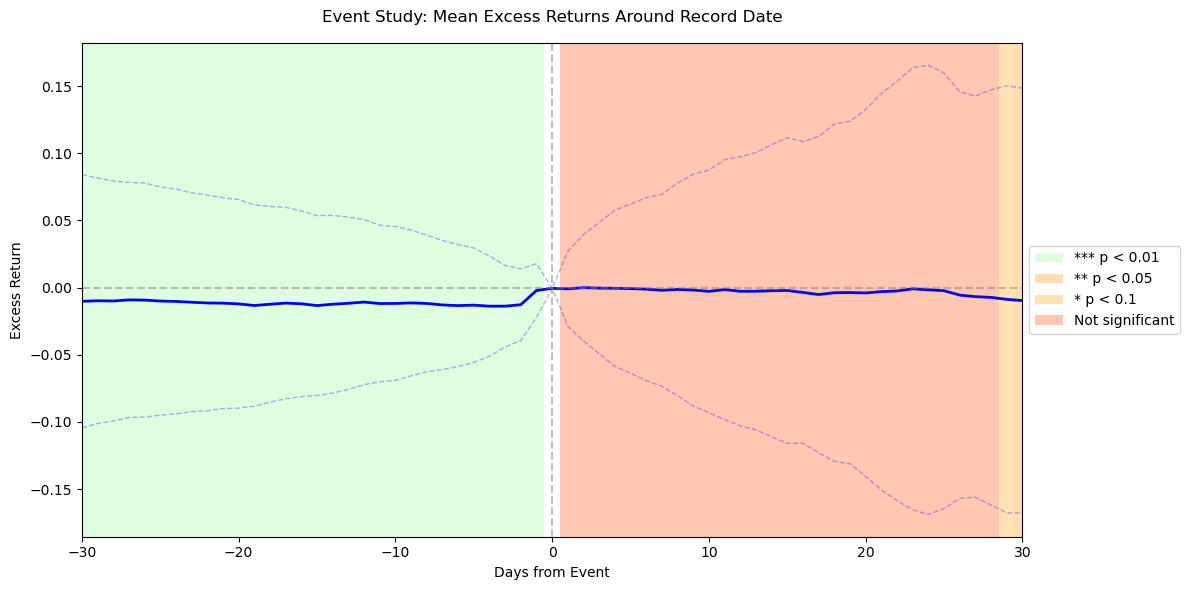


Number of events: 654
Number of companies: 77


In [312]:
# Create the visualization and get the statistics
fig, daily_stats = visualize_event_study(event_data)
plt.show()

# Print summary statistics
print("\nNumber of events:", len(event_data['event_date'].unique()))
print("Number of companies:", len(event_data['stock'].unique()))
